### all activities from user 1 and user 2

In [23]:
all_activities = ['Walking', 'Running', 'Commute in bus', 'Eating using fork and spoon', 
             'Using mobile phone(texting)', 'Working on laptop', 'Sitting', 'Washing hands',
             'Eating with hand', 'Conversing while sitting', 'Elevator', 'Opening door',
             'Standing', 'Climbing upstairs', 'Jogging', 'Video chat while sitting', 
             'Sleeping', 'Walking with hand in pocket', 'Writing']
columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Label']
hz = 36

In [28]:
import glob
import pandas as pd
def categorize(user):
    files = glob.glob('../../Dataset/User' + str(user) + '/*Accelerometer.csv')
    data = pd.DataFrame()
    activities = []  # current user's activity
    for name in files:
        data = data.append(pd.read_csv(name, usecols = columns))
    for i in range(len(all_activities)):
        tmp = data.loc[data['Label'] == i]
        print(all_activities[i], tmp.shape[0])
        if tmp.shape[0] < hz * 5:
            continue
        activities.append(all_activities[i])
        tmp.to_csv('./categorized_data/user' + str(user) + '_' + all_activities[i] + '.csv', index=False)
    return activities
user1_activities = categorize(1)
user2_activities = categorize(2)

Walking 73683
Running 60
Commute in bus 49244
Eating using fork and spoon 20156
Using mobile phone(texting) 16480
Working on laptop 201024
Sitting 34260
Washing hands 419
Eating with hand 4699
Conversing while sitting 5582
Elevator 8111
Opening door 2193
Standing 5311
Climbing upstairs 1462
Jogging 907
Video chat while sitting 0
Sleeping 0
Walking with hand in pocket 0
Writing 0
Walking 47091
Running 0
Commute in bus 0
Eating using fork and spoon 0
Using mobile phone(texting) 0
Working on laptop 113254
Sitting 0
Washing hands 1764
Eating with hand 0
Conversing while sitting 0
Elevator 1008
Opening door 0
Standing 11808
Climbing upstairs 0
Jogging 24454
Video chat while sitting 0
Sleeping 275160
Walking with hand in pocket 5148
Writing 86113


In [30]:
all_activities = {1:user1_activities, 2:user2_activities}
store([all_activities], ['all_activities'])

In [20]:
# all_activities = load(['data/all_activities'])[0]
user2_activities = all_activities[2]

In [31]:
def get_raw_data(user, activity):
    return pd.read_csv('./categorized_data/user' + str(user) + '_' + activity + '.csv')

from tqdm import tqdm
    
def create_segs(data, duration):
    data = data.iloc[:, :3] # get x, y, z acceleration
    result = data.values.tolist()
    segs = []
    length = len(result)
    for i in tqdm(range(0, length, hz * duration)):
        if i + duration * hz <= length:
            segs.append(result[i:i + duration * hz])
    return segs

In [3]:
import pickle
def store(files, names):
    for i in range(len(files)):
        pickle_out = open('data/' + names[i], "wb")
        pickle.dump(files[i], pickle_out)
        pickle_out.close()
def load(names):
    result = []
    for i in names:
        pickle_in = open(i, 'rb')
        result.append(pickle.load(pickle_in))
    return result

In [1]:
import numpy as np
from dtw_lib import _dtw_lib
from scipy.spatial.distance import euclidean

def distance(seg1, seg2, relax):
    distance, path, D = _dtw_lib.fastdtw(seg1, seg2, relax=relax, dist=euclidean)
    return distance
        
def find_medoid_seg(segs, user, activity, duration):
    length = len(segs)
    result = [0 for i in range(length)]
    table = [[-1 for i in range(length)] for i in range(length)] # initialize the table to all -1
    for i in tqdm(range(length)):
        for j in range(length):
            if i == j: 
                table[i][j] = 0
                continue
            elif table[j][i] != -1:  # using memoization
                table[i][j] = table[j][i]
                result[i] += table[i][j]
            else:
                table[i][j] = distance(segs[i], segs[j], 1)
                result[i] += table[i][j]
    store([table], ['user' + str(user) + '_' + activity + '_matrix_' + str(duration)])
    min_medoid = min(result)
    for i in range(len(result)):
        if min_medoid == result[i]:
            return segs[i], min_medoid / len(segs)

ImportError: cannot import name '_dtw_lib' from 'dtw_lib' (unknown location)

In [37]:
def calculate_medoids(user, activities, duration):
    import random
    all_segments = []
    medoids = []
    represents = []
    user_str = 'user' + str(user) + '_'
    for i in range(len(activities)):
        segs = create_segs(get_raw_data(user, activities[i]), duration)
        all_segments.append(segs)
        seg, medoid = find_medoid_seg(segs, user, activities[i], duration)
        represents.append(seg)
        medoids.append(medoid)
        name = [user_str + activities[i] + "_segments_" + str(duration)]
        store([segs], name)
    names = [user_str + "all_segments_" + str(duration), user_str + "medoids_" + str(duration), user_str + "represents_" + str(duration)]
    store([all_segments, medoids, represents], names)
    return all_segments, medoids, represents

In [38]:
for user in [1,2]: calculate_medoids(user, all_activities[user], 5)

 17%|█▋        | 104/629 [49:46<3:54:46, 26.83s/it]

KeyboardInterrupt: 

In [39]:
len(all_activities[1])

14

In [12]:
user2_segs = load(['data/user2_all_segments_5'])[0]

In [41]:
len(user1_segs)

14

In [82]:
def plot_matrix(matrix, activities, title, tag):
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    fig, ax = plt.subplots()
    im = ax.imshow(matrix)
    # set the ticks
    if tag:
        ax.set_xticks(np.arange(len(activities)))
        ax.set_yticks(np.arange(len(activities)))
        # set entry with labels
        ax.set_xticklabels(activities)
        ax.set_yticklabels(activities)
    title = "distance distribution for %s " % title 
    ax.set_title(title)
    fig.tight_layout()
    fig.colorbar(im, ax=ax)
    plt.show()
def plot_activity_matrix(file_name):
    plot_matrix(load([file_name])[0], None, file_name, False)

In [104]:
for i in range(14):
    print(user1_activities[i], len(user1_segs[i]))

Walking 409
Commute in bus 273
Eating using fork and spoon 111
Using mobile phone(texting) 91
Working on laptop 1116
Sitting 190
Washing hands 2
Eating with hand 26
Conversing while sitting 31
Elevator 45
Opening door 12
Standing 29
Climbing upstairs 8
Jogging 5


In [181]:
def convert_label_to_clusters(l):
    clusters = [[] for i in range(max(l) + 1)]
    for indx, value in enumerate(l):
        clusters[value].append(indx)
    return clusters
def normalize_clusters(clusters):
    return map(lambda l: sorted(l), clusters)

def print_cluster(clusters):
    normed = sorted(normalize_clusters(clusters))
    for i in normed:
        print(i)

### the ploted distance matrix

Walking 409


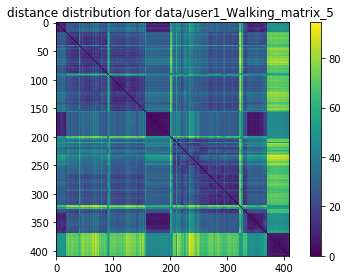

Commute in bus 273


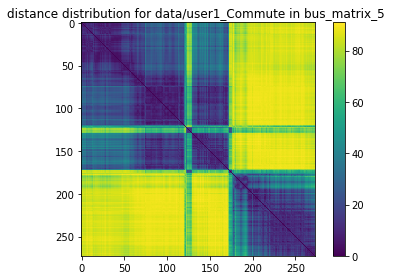

Eating using fork and spoon 111


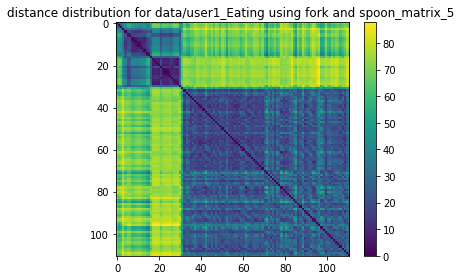

Using mobile phone(texting) 91


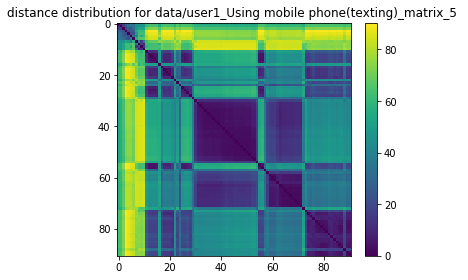

Working on laptop 1116


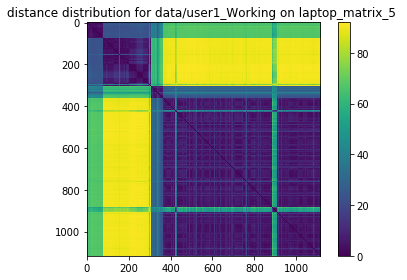

Sitting 190


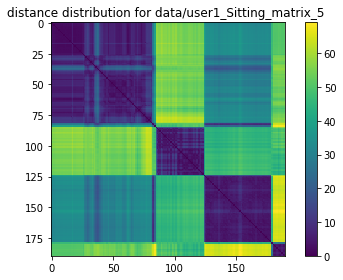

Washing hands 2


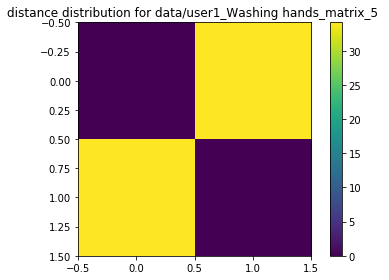

Eating with hand 26


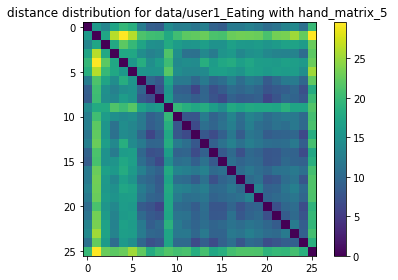

Conversing while sitting 31


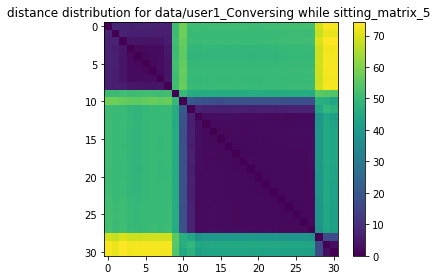

Elevator 45


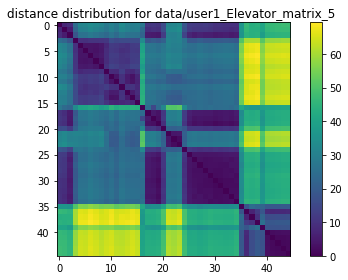

Opening door 12


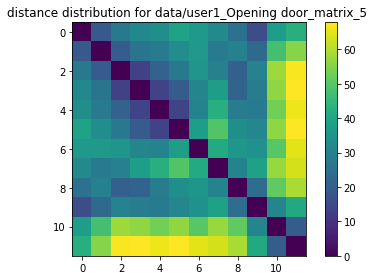

Standing 29


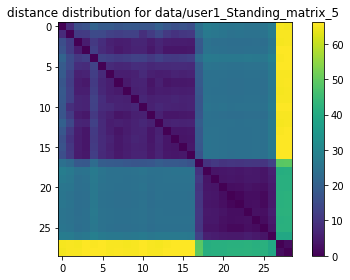

Climbing upstairs 8


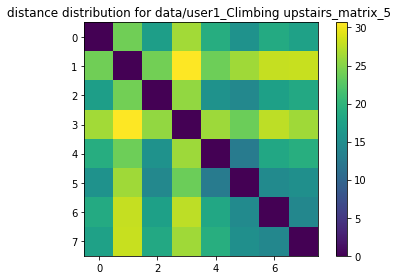

Jogging 5


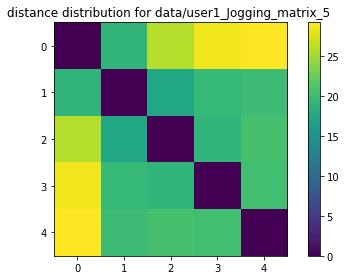

In [88]:
for i in range(14):
    print(user1_activities[i], len(user1_segs[i]))
    plot_activity_matrix('data/user1_' + user1_activities[i] +  '_matrix_5')

In [120]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
def hieratical_plot(i, method):
    matrix = load(['data/user1_' + user1_activities[i] +  '_matrix_5'])[0]
    f = lambda x, y: matrix[x[1]][y[1]]
    X = list(map(lambda x: [0, x], range(len(user1_segs[i]))))
    Y = pdist(X, f)
    linked = linkage(Y, method, metric = '')

    labelList = range(0, len(user1_segs[i]))

    plt.figure(figsize=(10, 7))  
    dendrogram(linked,  
                orientation='top',
                labels=labelList,
                distance_sort='descending',
                show_leaf_counts=True)
    plt.title(user1_activities[i] + "======" + method)
    plt.show()  

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
def hieratical_plot2(i, method):
    matrix = load(['data/user2_' + user2_activities[i] +  '_matrix_5'])[0]
    f = lambda x, y: matrix[x[1]][y[1]]
    X = list(map(lambda x: [0, x], range(len(user2_segs[i]))))
    Y = pdist(X, f)
    linked = linkage(Y, method, metric = '')

    labelList = range(0, len(user2_segs[i]))

    plt.figure(figsize=(10, 7))  
    dendrogram(linked,  
                orientation='top',
                labels=labelList,
                distance_sort='descending',
                show_leaf_counts=True)
    plt.title(user2_activities[i] + "======" + method)
    plt.show() 

In [22]:
user2_activities[4]
hieratical_plot2(4, 'average')

IndexError: list index out of range

### the hieratical diagram for user1 activities

Walking 409


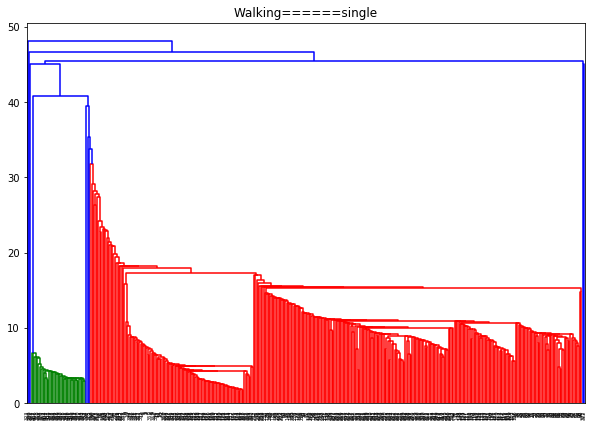

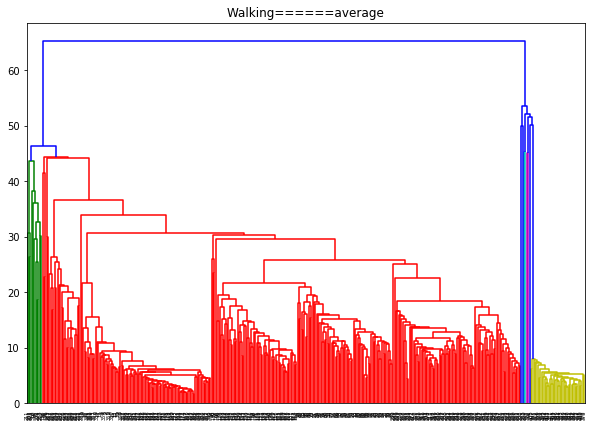

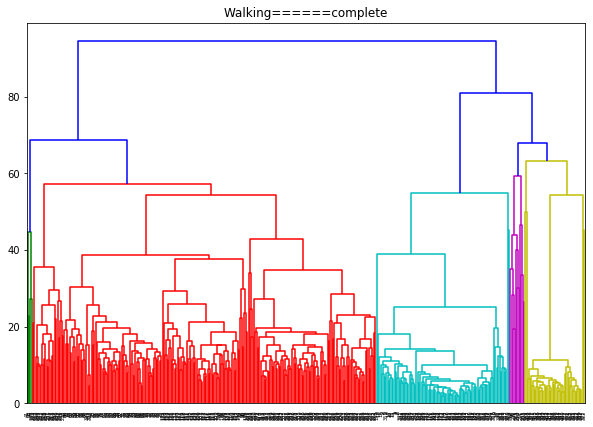

Commute in bus 273


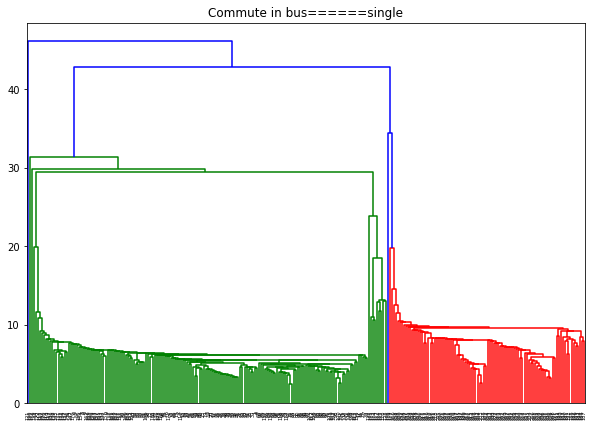

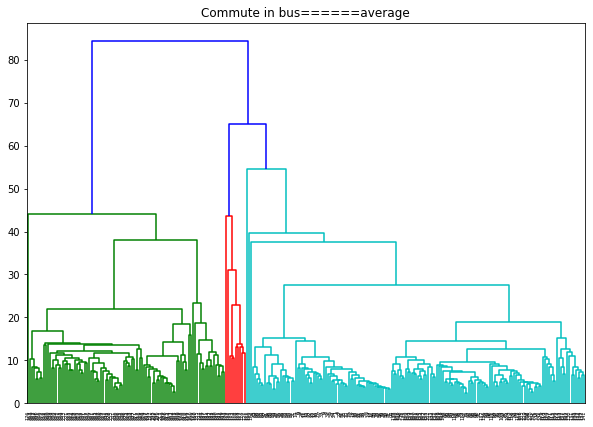

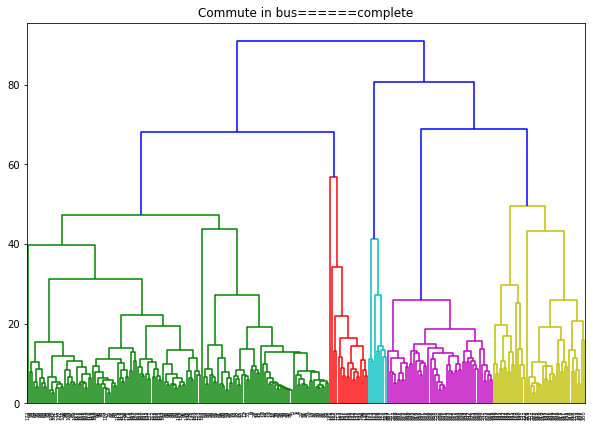

Eating using fork and spoon 111


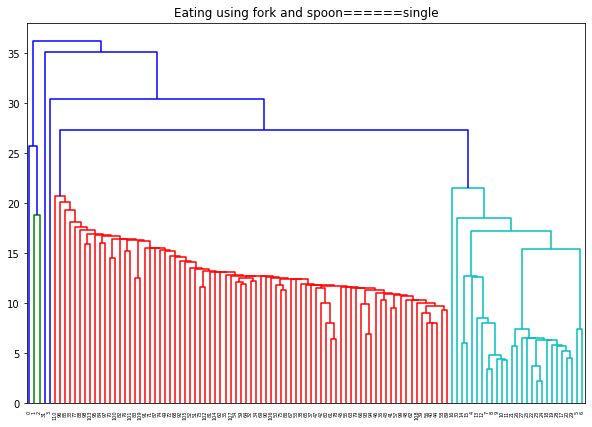

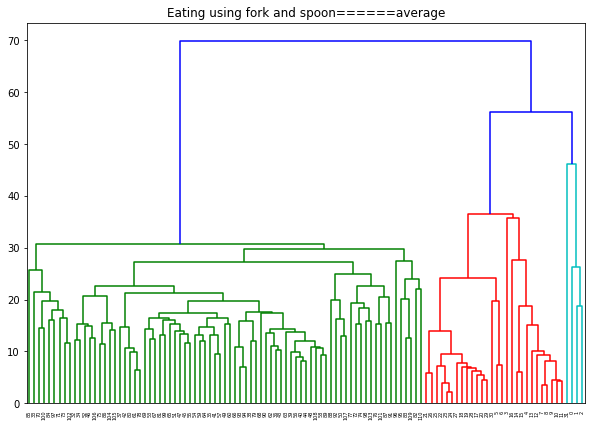

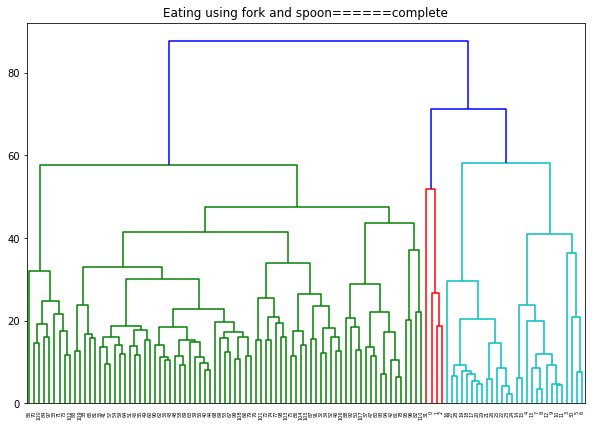

Using mobile phone(texting) 91


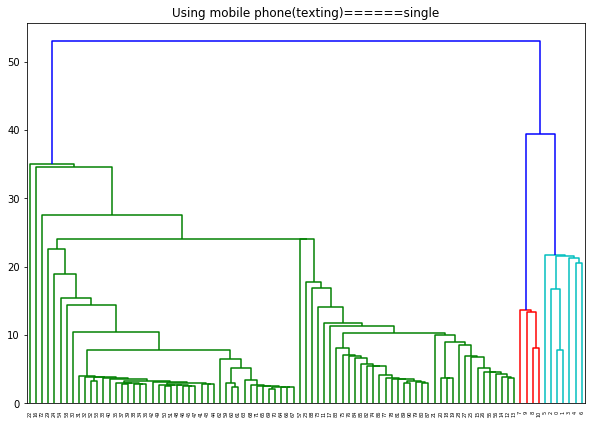

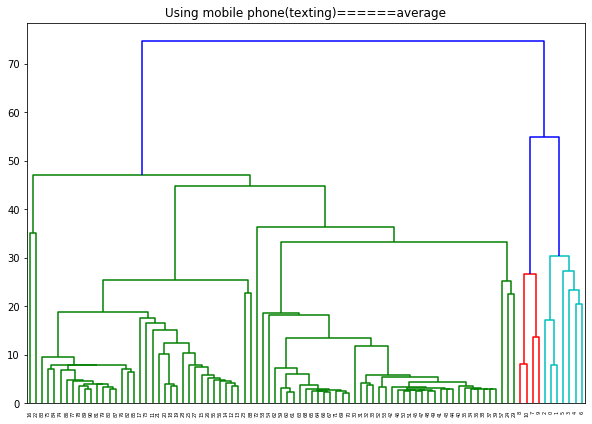

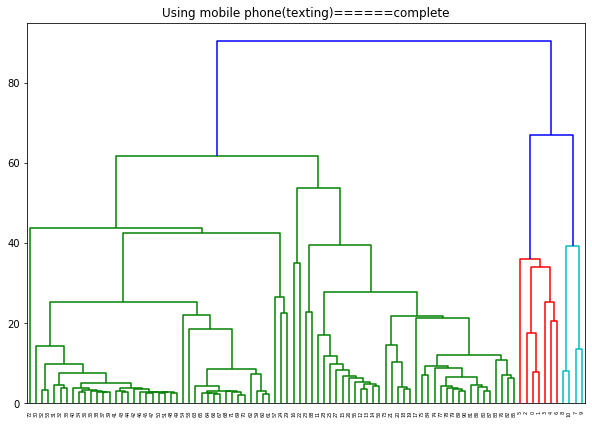

Working on laptop 1116


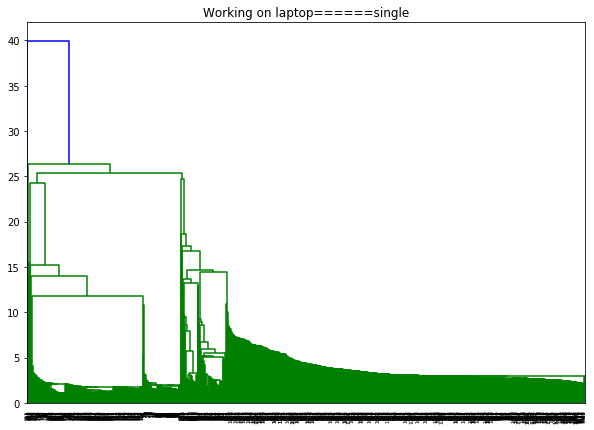

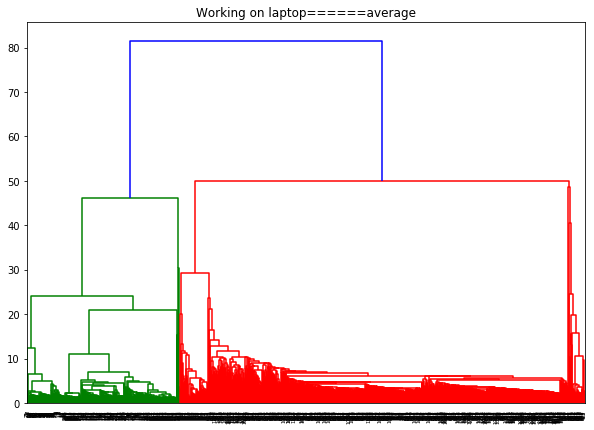

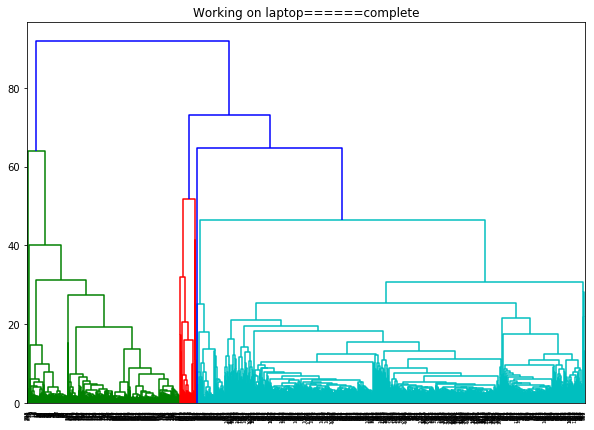

Sitting 190


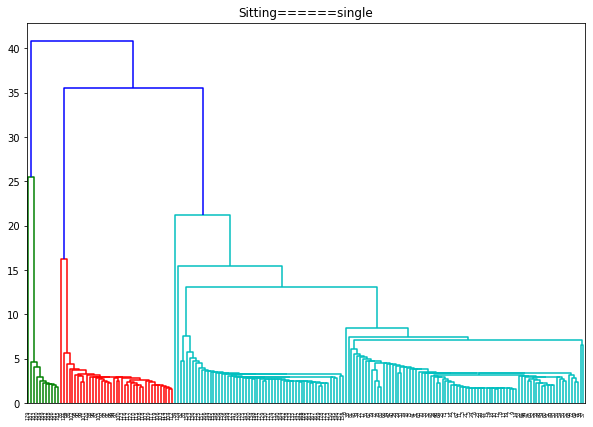

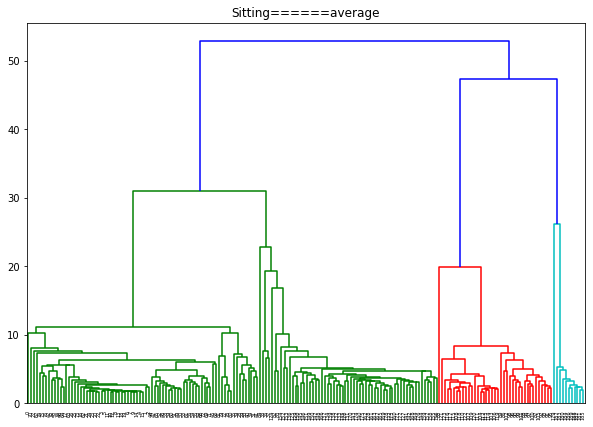

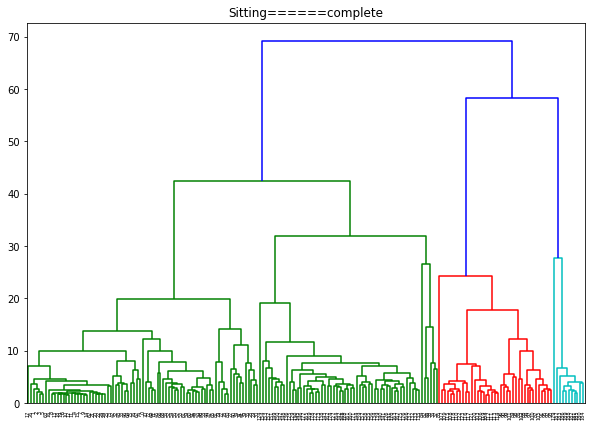

Washing hands 2


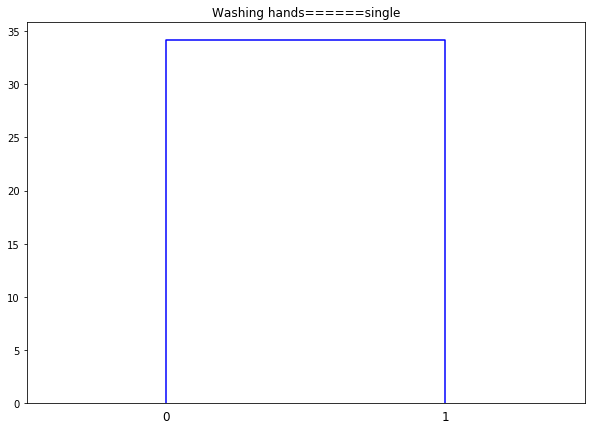

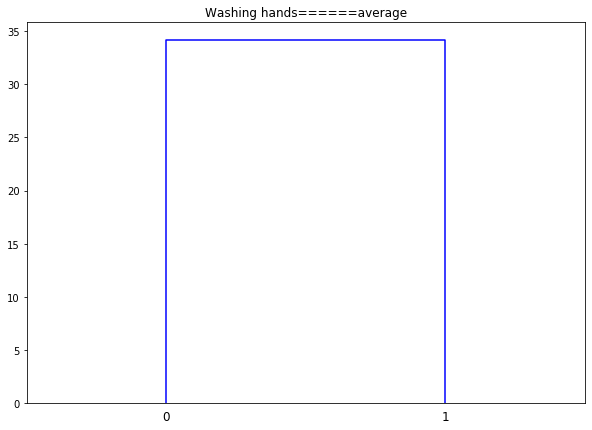

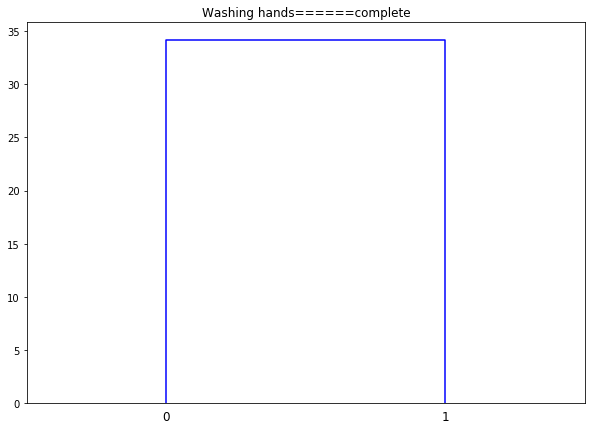

Eating with hand 26


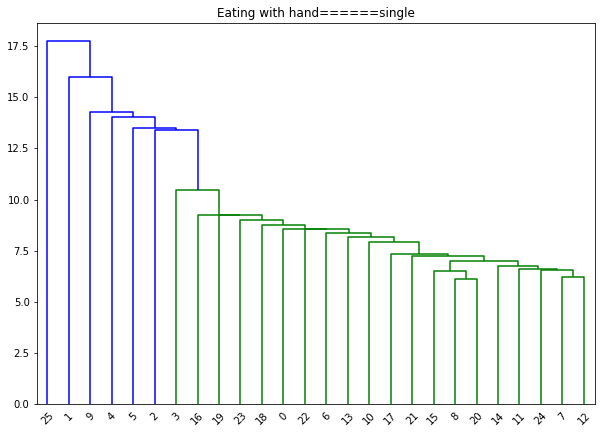

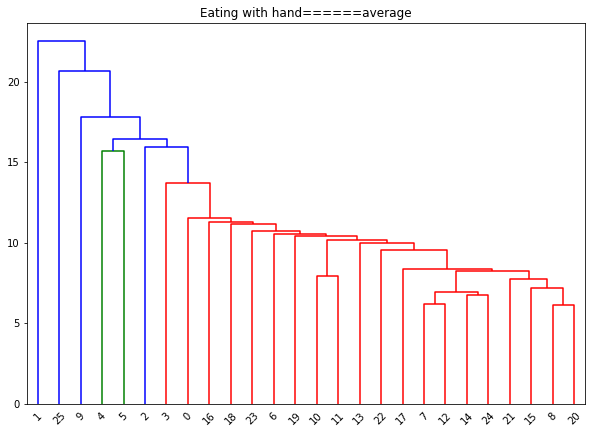

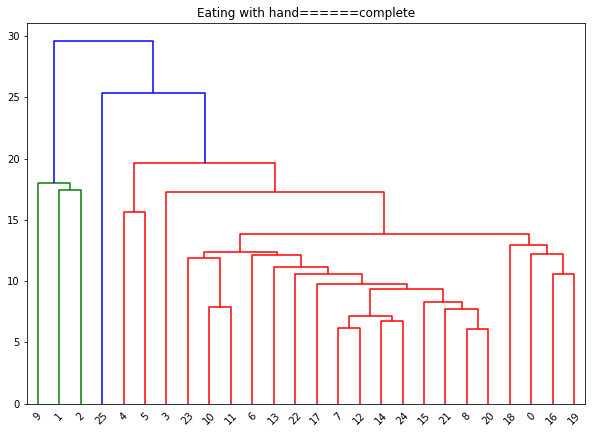

Conversing while sitting 31


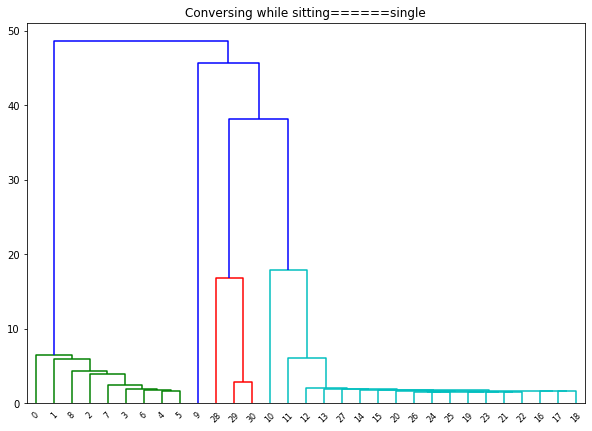

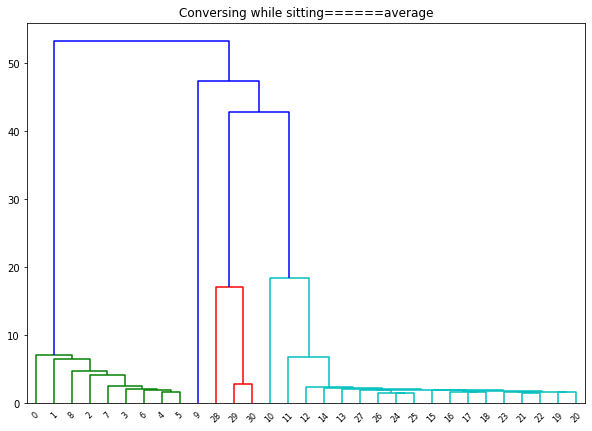

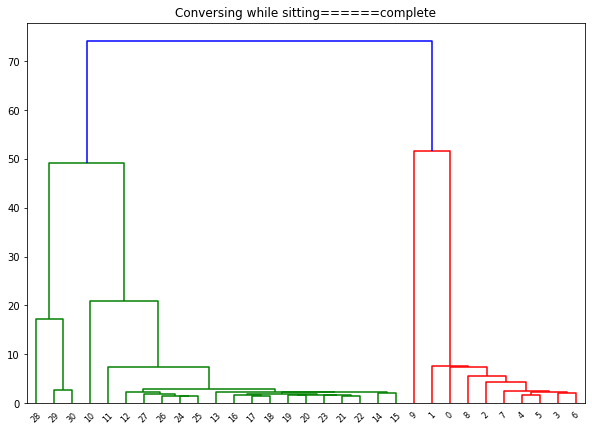

Elevator 45


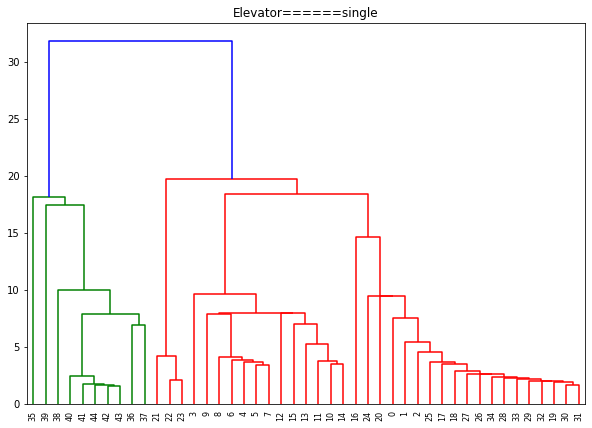

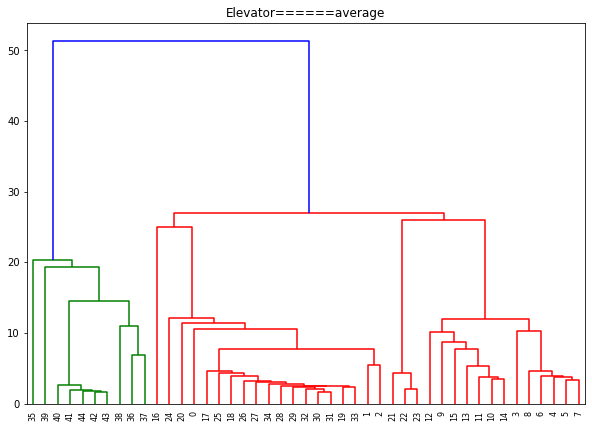

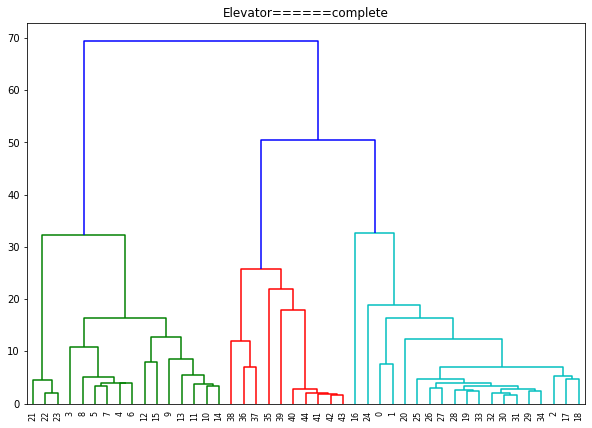

Opening door 12


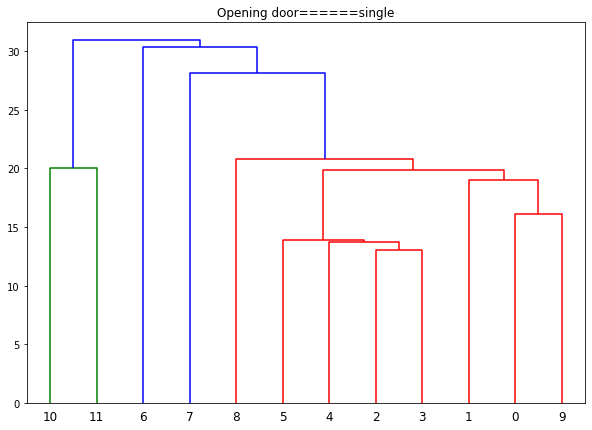

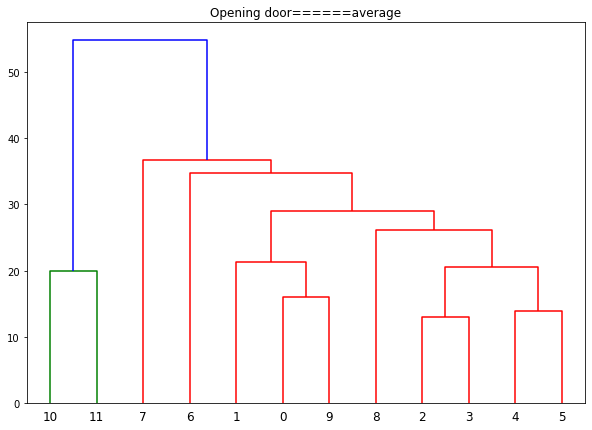

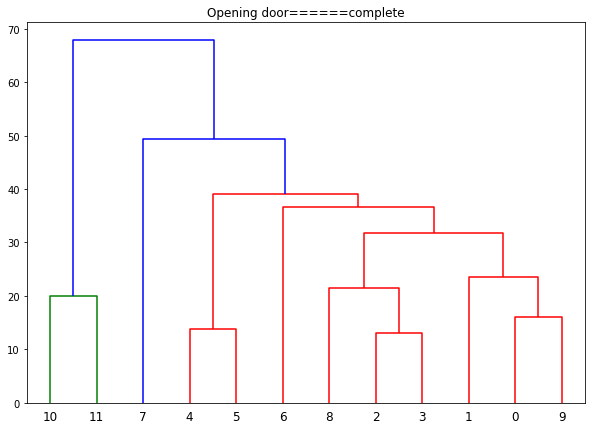

Standing 29


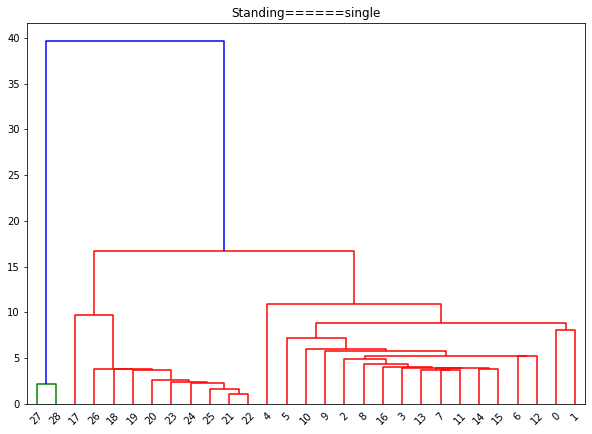

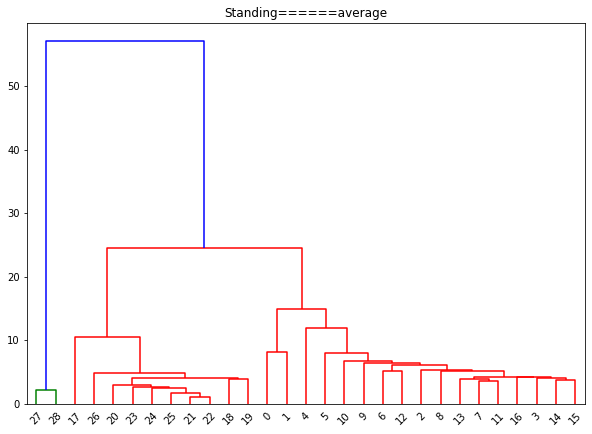

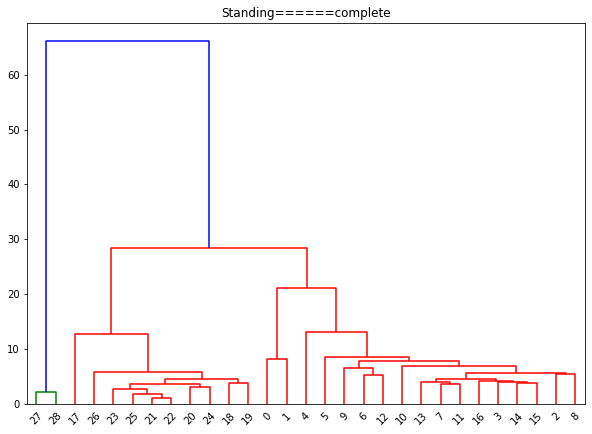

Climbing upstairs 8


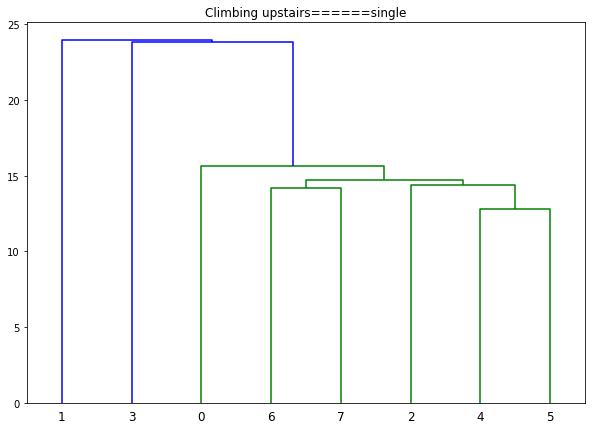

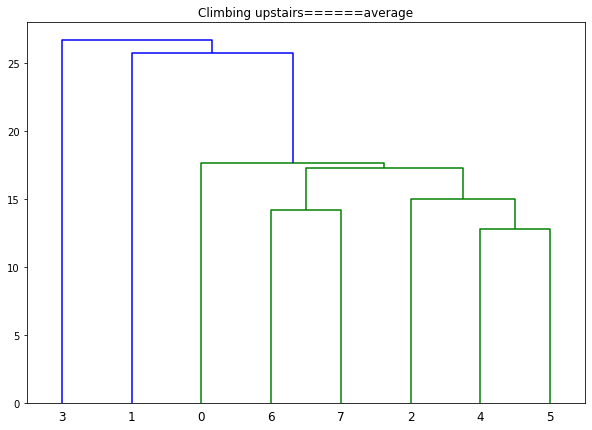

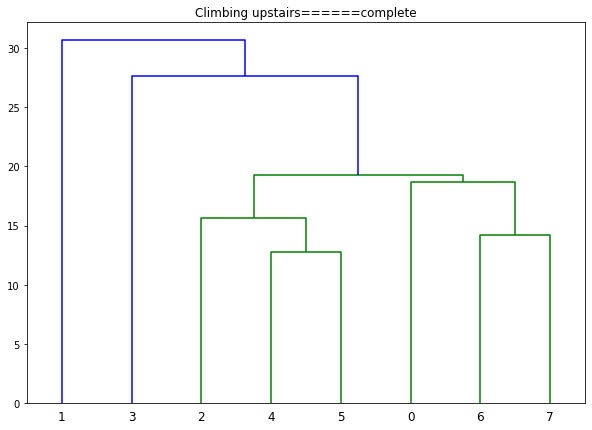

Jogging 5


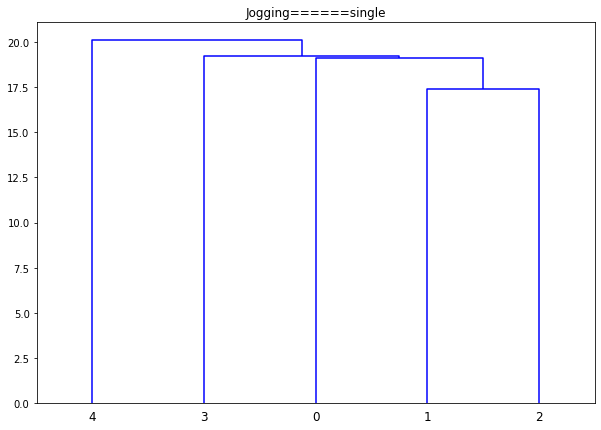

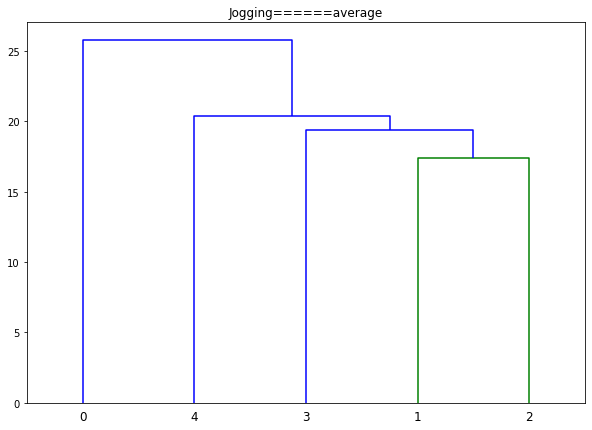

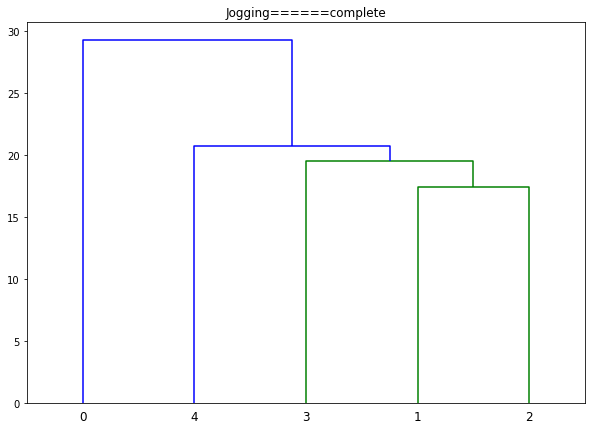

In [122]:
for i in range(14):
    print(user1_activities[i], len(user1_segs[i]))
    hieratical_plot(i, 'single')
    hieratical_plot(i, 'average')
    hieratical_plot(i, 'complete')

In [267]:
from sklearn.cluster import AgglomerativeClustering
def get_hieratical_cluster(index, num_cluster):
    matrix = load(['data/user1_' + user1_activities[index] +  '_matrix_5'])[0]
    cluster = AgglomerativeClustering(n_clusters=num_cluster, affinity='precomputed', linkage='complete')  
    return cluster.fit_predict(matrix)

In [214]:
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.kmedoids import kmedoids
import random
def get_kmedois_cluster(index, num_medoids):
    matrix = load(['data/user1_' + user1_activities[index] +  '_matrix_5'])[0]
    f = lambda x, y: matrix[x][y]
    metric = distance_metric(type_metric.USER_DEFINED, func=f)
    segs = list(range(len(user1_segs[index])))
    init = random.sample(segs, num_medoids)
    kmedoids_instance = kmedoids(segs, init, metric=metric);
    # run cluster analysis and obtain results
    kmedoids_instance.process()
    return kmedoids_instance.get_clusters();

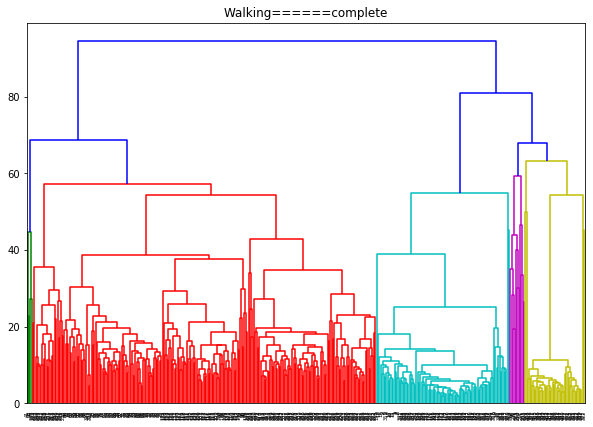

In [270]:
hieratical_plot(0, 'complete')

In [247]:
def compare_hieratical_k_medoid_cluster(index, num_cluster):
    print(user1_activities[index] + '=======' + str(len(user1_segs[index])))
    labels = get_hieratical_cluster(index, num_cluster)
    print('from hieratical_cluster')
    print_cluster(convert_label_to_clusters(labels))
    clusters = get_kmedois_cluster(index, num_cluster)
    print('from k medoids cluster')
    print_cluster(clusters)

In [271]:
get_hieratical_cluster(0, 2)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [272]:
compare_hieratical_k_medoid_cluster(0, 2)

Walking=======409
from hieratical_cluster
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 90, 91, 92, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 210, 211, 319, 320, 321, 322, 323, 324, 325, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408]
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73